In [1]:
import numpy as np
import matplotlib.pyplot as plt
import cv2
import torch
import torch.nn as nn
from torchvision import models
from torch.nn.functional import relu, one_hot, cross_entropy
from IPython.display import clear_output
from scipy.ndimage import distance_transform_edt

1. Data preperation (preprocess)

NOTE TO SELF: The images should be of consistent dimensions for better results. This notebook specifically overfits one case. Although UNET is fully convolutional, the dimensions must be divisible by the downsampling operations (dimensions%2^n = 0)

In [2]:
img = cv2.imread('../data/raw/images/8013620831-0043.jpg-t.jpg')
mask = cv2.imread('../data/raw/masks/8013620831-0043.jpg-t.png')

In [3]:
_, img = cv2.threshold(img, 25, 255, cv2.THRESH_BINARY)
kernel = np.ones((3, 3), np.uint8)  # 3x3 kernel for small erosion
img = cv2.erode(img, kernel, iterations=2)
img = img / 255.0

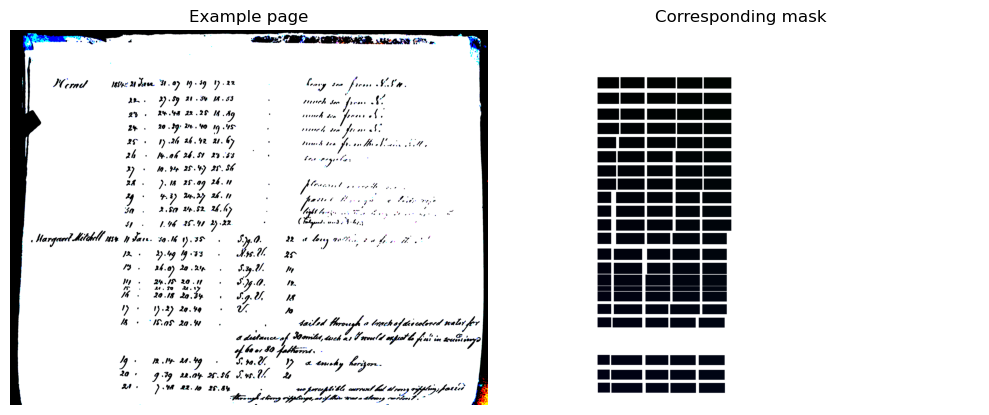

In [4]:
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.imshow(img, cmap='gray')
plt.axis('off')
plt.title('Example page')

plt.subplot(1, 2, 2)
plt.imshow(mask)
plt.axis('off')
plt.title('Corresponding mask')

plt.tight_layout()
plt.show()

In [5]:
# red = rows
# green = columns (we care about this)
green_channel = mask[:, :, 1] # 1 for green since (R, G, B)
class_mask = np.zeros_like(green_channel)

class_mask[green_channel == 1] = 0  # Year 
class_mask[green_channel == 2] = 1  # Date
class_mask[green_channel == 3] = 2  # Latitude
class_mask[green_channel == 4] = 3  # Longitude
class_mask[green_channel == 5] = 4  # Water Temperature
class_mask[green_channel == 255] = 5  # Background

mask_class = torch.tensor(class_mask, dtype=torch.long)
one_hot_mask = one_hot(mask_class, num_classes=6)

print(one_hot_mask.shape)  # [height, width, num_classes]

torch.Size([2816, 3581, 6])


Checking if we have correctly one-hot encoded the classes (being columns and background)

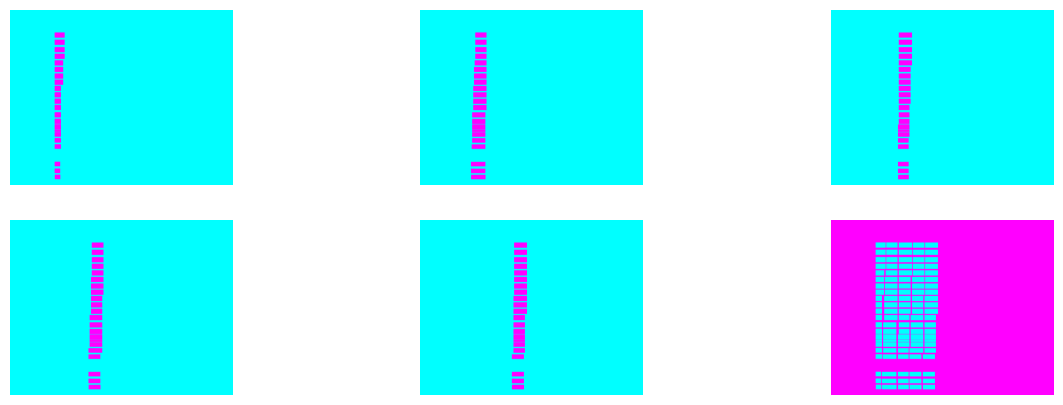

In [6]:
plt.figure(figsize=(15, 5))

for i in range(0, 6):
    plt.subplot(2, 3, i+1)
    plt.imshow(one_hot_mask[..., i], cmap='cool')
    plt.axis('off')

plt.show()


2. UNET

In [7]:
class UNet(nn.Module):
    def __init__(self, n_class):
        super().__init__()
        
        # Encoder
        self.e11 = nn.Conv2d(3, 64, kernel_size=3, padding=1)
        self.bn11 = nn.BatchNorm2d(64)
        self.e12 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.bn12 = nn.BatchNorm2d(64)
        self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e21 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.bn21 = nn.BatchNorm2d(128)
        self.e22 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.bn22 = nn.BatchNorm2d(128)
        self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e31 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
        self.bn31 = nn.BatchNorm2d(256)
        self.e32 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.bn32 = nn.BatchNorm2d(256)
        self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e41 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
        self.bn41 = nn.BatchNorm2d(512)
        self.e42 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.bn42 = nn.BatchNorm2d(512)
        self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)

        self.e51 = nn.Conv2d(512, 1024, kernel_size=3, padding=1)
        self.bn51 = nn.BatchNorm2d(1024)
        self.e52 = nn.Conv2d(1024, 1024, kernel_size=3, padding=1)
        self.bn52 = nn.BatchNorm2d(1024)

        # Decoder
        self.upconv1 = nn.ConvTranspose2d(1024, 512, kernel_size=2, stride=2)
        self.d11 = nn.Conv2d(1024, 512, kernel_size=3, padding=1)
        self.dbn11 = nn.BatchNorm2d(512)
        self.d12 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
        self.dbn12 = nn.BatchNorm2d(512)

        self.upconv2 = nn.ConvTranspose2d(512, 256, kernel_size=2, stride=2)
        self.d21 = nn.Conv2d(512, 256, kernel_size=3, padding=1)
        self.dbn21 = nn.BatchNorm2d(256)
        self.d22 = nn.Conv2d(256, 256, kernel_size=3, padding=1)
        self.dbn22 = nn.BatchNorm2d(256)

        self.upconv3 = nn.ConvTranspose2d(256, 128, kernel_size=2, stride=2)
        self.d31 = nn.Conv2d(256, 128, kernel_size=3, padding=1)
        self.dbn31 = nn.BatchNorm2d(128)
        self.d32 = nn.Conv2d(128, 128, kernel_size=3, padding=1)
        self.dbn32 = nn.BatchNorm2d(128)

        self.upconv4 = nn.ConvTranspose2d(128, 64, kernel_size=2, stride=2)
        self.d41 = nn.Conv2d(128, 64, kernel_size=3, padding=1)
        self.dbn41 = nn.BatchNorm2d(64)
        self.d42 = nn.Conv2d(64, 64, kernel_size=3, padding=1)
        self.dbn42 = nn.BatchNorm2d(64)

        self.outconv = nn.Conv2d(64, n_class, kernel_size=1)
        
        # Initialize weights
        self._initialize_weights()

    def _initialize_weights(self):
        for m in self.modules():
            if isinstance(m, nn.Conv2d) or isinstance(m, nn.ConvTranspose2d):
                nn.init.kaiming_normal_(m.weight, mode='fan_out', nonlinearity='relu')
                if m.bias is not None:
                    nn.init.constant_(m.bias, 0)
            elif isinstance(m, nn.BatchNorm2d):
                nn.init.constant_(m.weight, 1)
                nn.init.constant_(m.bias, 0)

    def forward(self, x):
        # Encoder
        xe11 = relu(self.bn11(self.e11(x)))
        xe12 = relu(self.bn12(self.e12(xe11)))
        xp1 = self.pool1(xe12)

        xe21 = relu(self.bn21(self.e21(xp1)))
        xe22 = relu(self.bn22(self.e22(xe21)))
        xp2 = self.pool2(xe22)

        xe31 = relu(self.bn31(self.e31(xp2)))
        xe32 = relu(self.bn32(self.e32(xe31)))
        xp3 = self.pool3(xe32)

        xe41 = relu(self.bn41(self.e41(xp3)))
        xe42 = relu(self.bn42(self.e42(xe41)))
        xp4 = self.pool4(xe42)

        xe51 = relu(self.bn51(self.e51(xp4)))
        xe52 = relu(self.bn52(self.e52(xe51)))
        
        # Decoder
        xu1 = self.upconv1(xe52)
        xu11 = torch.cat([xu1, xe42], dim=1)
        xd11 = relu(self.dbn11(self.d11(xu11)))
        xd12 = relu(self.dbn12(self.d12(xd11)))

        xu2 = self.upconv2(xd12)
        xu22 = torch.cat([xu2, xe32], dim=1)
        xd21 = relu(self.dbn21(self.d21(xu22)))
        xd22 = relu(self.dbn22(self.d22(xd21)))

        xu3 = self.upconv3(xd22)
        xu33 = torch.cat([xu3, xe22], dim=1)
        xd31 = relu(self.dbn31(self.d31(xu33)))
        xd32 = relu(self.dbn32(self.d32(xd31)))

        xu4 = self.upconv4(xd32)
        xu44 = torch.cat([xu4, xe12], dim=1)
        xd41 = relu(self.dbn41(self.d41(xu44)))
        xd42 = relu(self.dbn42(self.d42(xd41)))

        out = self.outconv(xd42)
        
        return out

3. Training Configuration

In [8]:
# HYPERPARAMS
BATCH_SIZE = 16
SIGMA = 10
EPOCHS = 200
LEARNING_RATE = 1e-4
N_CLASSES = 6
TARGET_SIZE = (1024, 1024)

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("device:", device)

device: cuda


In [9]:
def create_background_weights(mask, sigma=10.0):
    """
    Create weights for background pixels based on distance to non-background objects.
    
    Args:
        mask: Tensor of shape [height, width, num_classes]
        sigma: Parameter to control the decay of weights with distance
    
    Returns:
        weights: Tensor of same shape as input with higher weights for background pixels between objects
    """
    mask_np = mask.cpu().numpy()
    non_background = np.zeros_like(mask_np[..., 0])
    for i in range(5):  # excluding background class (5)
        non_background = np.logical_or(non_background, mask_np[..., i] > 0)
    
    distances = distance_transform_edt(~non_background) # how far each pixel is from any non-background object.
    weights = np.exp(-distances**2 / (2 * sigma**2)) # pixels closer get high weights; further get low weights

    
    class_weights = torch.ones_like(mask)
    class_weights[..., -1] = torch.from_numpy(weights).float()  # apply weights to background class
    return class_weights.to(mask.device)

class WeightedSegmentationLoss(nn.Module):
    def __init__(self):
        super().__init__()
        
    def forward(self, pred, target):
        weights = create_background_weights(target.squeeze(0), SIGMA)

        # pred shape: [batch_size, num_classes, height, width]
        # target shape: [batch_size, height, width, num_classes]
        target = target.permute(0, 3, 1, 2) 
        weights = weights.permute(2, 0, 1).unsqueeze(0)
        
        loss = cross_entropy(pred, target, reduction='none')
        loss = loss * weights
        return loss.mean()

In [10]:
model = UNet(N_CLASSES).to(device)
criterion = WeightedSegmentationLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LEARNING_RATE)

4. Train model

In [11]:
img_resized = cv2.resize(img, TARGET_SIZE, interpolation=cv2.INTER_AREA)
img_tensor = torch.from_numpy(img_resized).permute(2, 0, 1).float().unsqueeze(0).to(device)

mask_resized = cv2.resize(class_mask, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)
mask_class_resized = torch.tensor(mask_resized, dtype=torch.long)
one_hot_mask_resized = one_hot(mask_class_resized, num_classes=6)
mask_tensor = one_hot_mask_resized.permute(2, 0, 1).float().unsqueeze(0).to(device)

Penalty for background pixels between objects

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


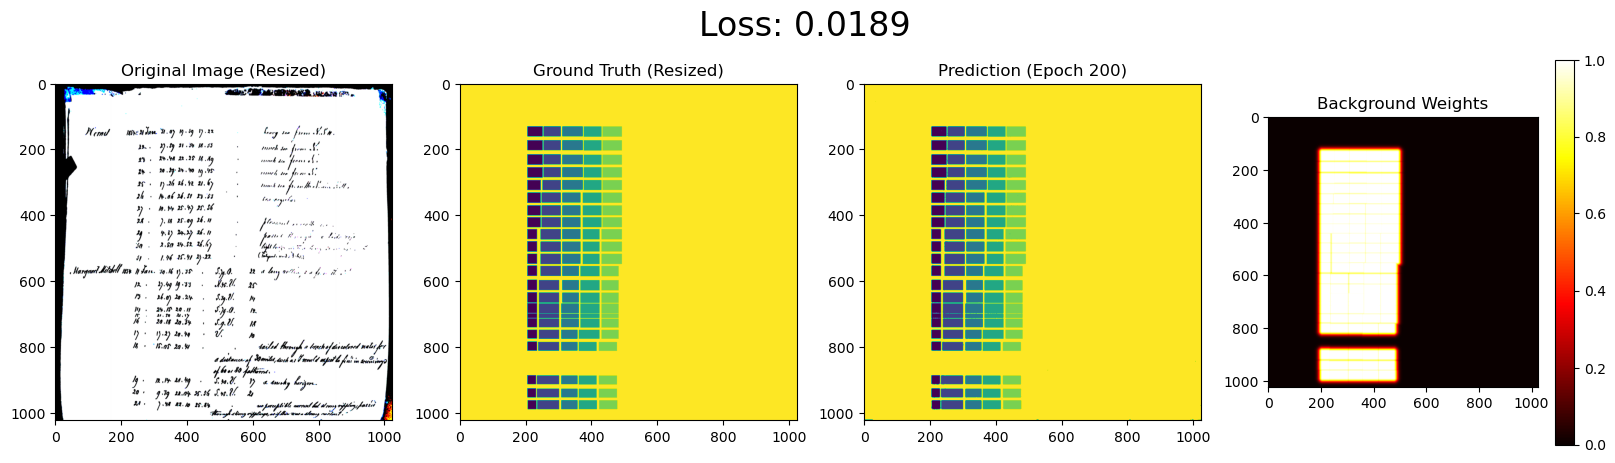

In [12]:
scaler = torch.cuda.amp.GradScaler()
torch.cuda.empty_cache()

mask_tensor = mask_tensor.permute(0, 2, 3, 1)  # [batch, height, width, num_classes]
loss_values = []


for epoch in range(EPOCHS):
    model.train()
    optimizer.zero_grad()
    
    # Forward pass with mixed precision
    with torch.cuda.amp.autocast():
        outputs = model(img_tensor)  # [batch, num_classes, height, width]
        loss = criterion(outputs, mask_tensor)
    
    # Backward pass with gradient scaling
    scaler.scale(loss).backward()
    scaler.step(optimizer)
    scaler.update()
    loss_values.append(loss.item())
    
    # Visualization
    if (epoch + 1) % 5 == 0:
        clear_output(wait=True)
        with torch.no_grad():
            model.eval()
            pred = outputs.squeeze(0).cpu()
            pred = torch.argmax(pred, dim=0).numpy()
            
            weight_map = create_background_weights(mask_tensor.squeeze(0)).cpu().numpy()[..., -1]
            weight_map = cv2.resize(weight_map, TARGET_SIZE, interpolation=cv2.INTER_NEAREST)
        
            plt.figure(figsize=(20, 5))
            
            plt.subplot(1, 4, 1)
            plt.imshow(img_resized)
            plt.title('Original Image (Resized)')
            
            plt.subplot(1, 4, 2)
            plt.imshow(mask_resized)
            plt.title('Ground Truth (Resized)')
            
            plt.subplot(1, 4, 3)
            plt.imshow(pred)
            plt.title(f'Prediction (Epoch {epoch+1})')
            
            plt.subplot(1, 4, 4)
            plt.imshow(weight_map, cmap='hot')
            plt.colorbar()
            plt.title('BG Weights')
            
            plt.suptitle(f'Loss: {loss.item():.4f}', fontsize=24)
            plt.show()

torch.save(model.state_dict(), 'overfitted_model_w_penalty.pth')

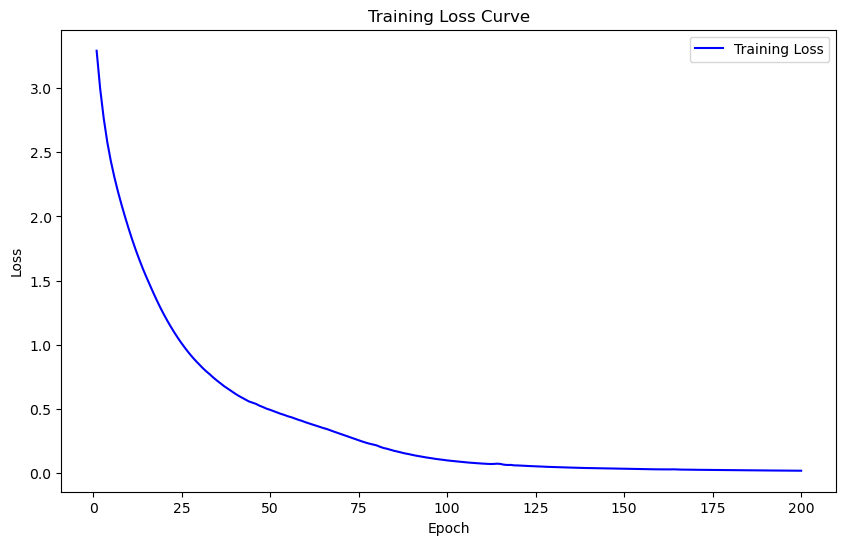

In [13]:
plt.figure(figsize=(10, 6))
plt.plot(range(1, EPOCHS + 1), loss_values, label='Training Loss', color='blue')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Training Loss Curve')
plt.legend()
plt.show()